In [3]:
#Imports
%matplotlib widget
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from Imports import edge_detection
from fractions import Fraction

(4032, 3024, 3)
(1008, 756, 3)


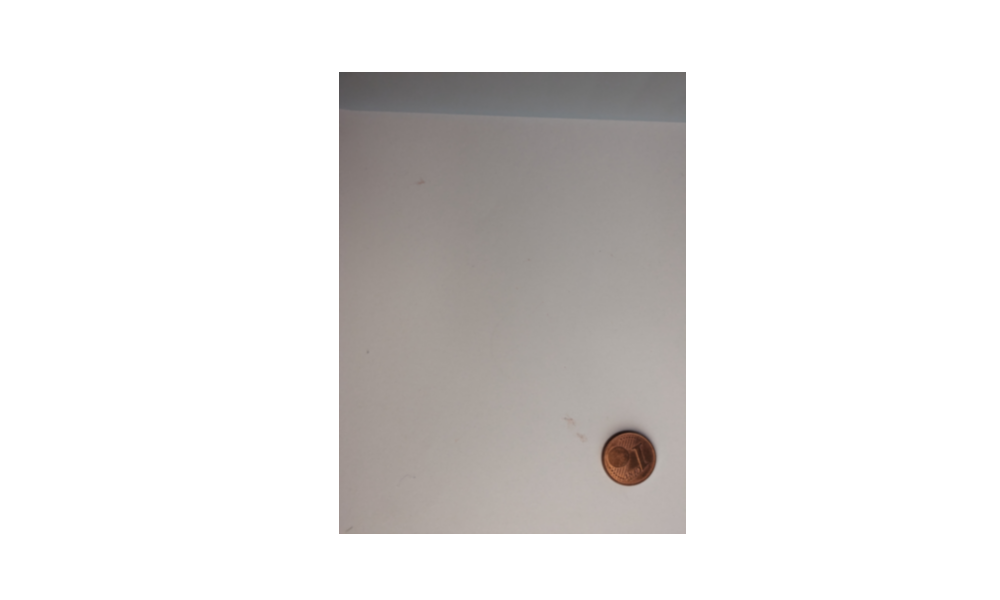

In [6]:
# Load, Resize, Blur and display Image
im = cv.imread("Images/1cent/coin1.jpg")
print(im.shape)
im = cv.resize(im, dsize=(0, 0), fx=0.25, fy=0.25, interpolation=cv.INTER_CUBIC)
print(im.shape)
im = cv.GaussianBlur(im,(7, 7),0)

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.set_axis_off()
axs.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
plt.show()


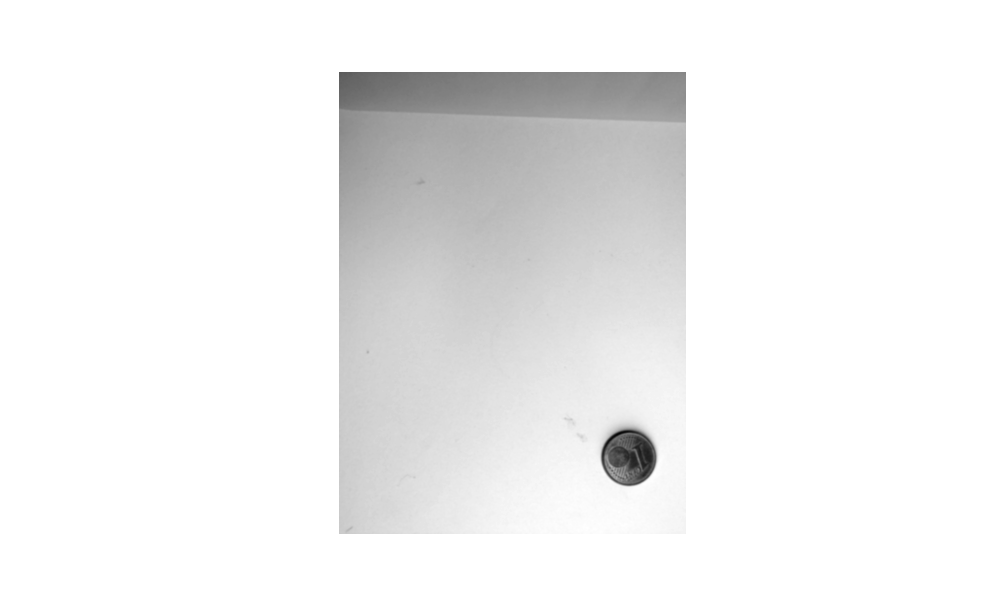

In [7]:
# Convert to Gray Scale
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.set_axis_off()
axs.imshow(im_gray, cmap="gray")
plt.show()


c:\Users\jason\OneDrive\Υπολογιστής\CSD\Computer Vision\Assignment-03\Imports\edge_detection.py:70: RuntimeWarning: divide by zero encountered in divide
  angle = np.arctan(dX / dY)


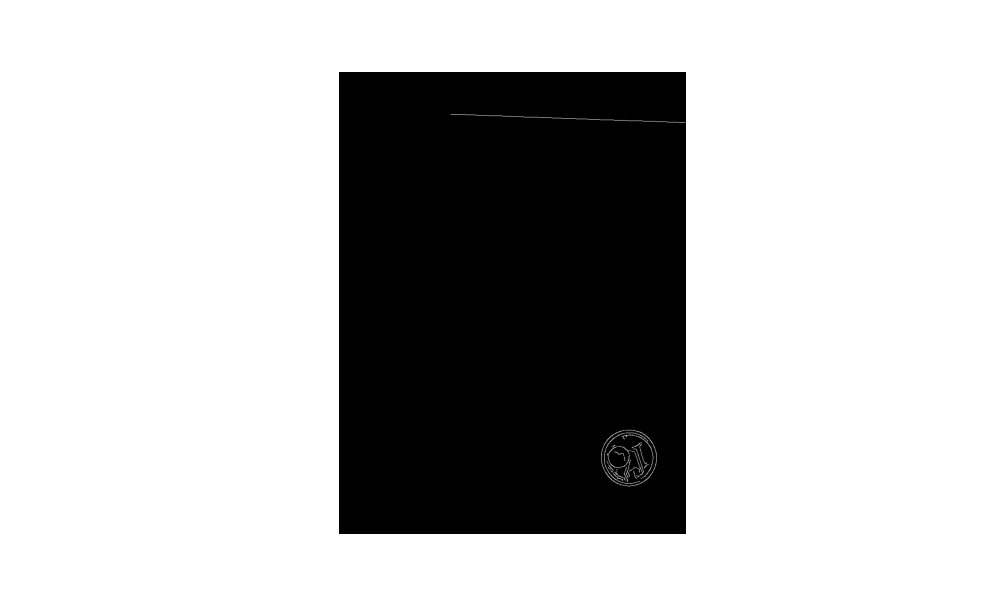

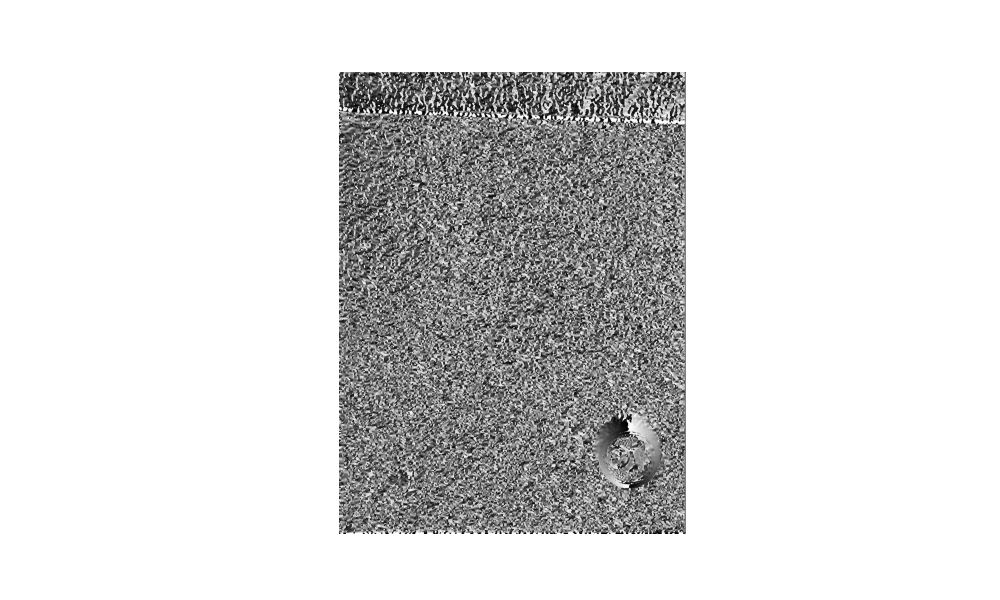

In [8]:
# Apply Canny Edge detector on gray scale image
out_final, out_thresh, angle, edge_pixels = edge_detection.Canny(im_gray, 20, 80, 3)
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.set_axis_off()
axs.imshow(out_final, cmap="gray")
plt.show()


fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.set_axis_off()
axs.imshow(angle, cmap="gray")
plt.show()

In [19]:
def preprocess_image(path, sf=0.15, gaussian_kernel=5, thresh1=20, thresh2=100, canny_kernel=3):
    '''
    Contains all preprocessing needed to implement Circle Hough Transform
    Parameters:
        - path: The image path relative to the file location
        - sf: The scaling factor with which to subsample the image
        - gaussian kernel: The blurring to apply
        - thresh1: Canny threshold no1
        - thresh2: Canny threshold no2
        - canny_kernel: The sobel kernel size 
    
    Returns:
        - out_final: The image containing edge and non-edge pixels
        - angle: An array of shape equal to that of the input image, that contains the gradient angles at each pixel
        - edge_pixels: A list of edge pixels in a [(xi, yi), (xi+1, yi+1), ...] format
    '''
    im = cv.imread(path)
    im_resized = cv.resize(im, dsize=(0, 0), fx=sf, fy=sf, interpolation=cv.INTER_CUBIC)
    im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    im_gray = cv.resize(im_gray, dsize=(0, 0), fx=sf, fy=sf, interpolation=cv.INTER_CUBIC)
    im_gray = cv.GaussianBlur(im_gray,(gaussian_kernel, gaussian_kernel),0)
    out_final, magn, angle, edge_pixels = edge_detection.Canny(im_gray, thresh1, thresh2, canny_kernel)

    return out_final, magn, angle, edge_pixels, im_gray, im_resized


def fine_tune_circle(canny_init, radius, x_center, y_center, threshold, k=6):
    '''
    Fine Tunes the detected circles and suppresses edge pixels that correspond to identified circles so that they cannot be reused
    Parameters:
        - canny_init: The canny edge detection output image containing edge pixels and non-edge pixels
        - radius: the radius of the input circle
        - x_center: the x-coordinate of the circle center
        - y_center: the y-coordinate of the circle center
        - threshold: the threshold with which to suppress low scoring circles
        - k: the size of the marker with which to erase edge pixels

    Returns:
        - circle: (y, x, r) of the fine-tunned circle
        - canny_init: the transformed canny output with the erased edge pixels
    '''
    max = 0
    width = canny_init.shape[1]
    height = canny_init.shape[0]
    for cand_x in [x_center-1, x_center, x_center+1]:
        for cand_y in [y_center-1, y_center, y_center+1]:
            for cand_r in [radius-1, radius, radius+1]:
                canny = canny_init.copy()
                correlation = 0
                list_of_points = []
                x = round(-cand_r)
                y = 0
                list_of_points.append((y, x))
                # Start from pixel (y_center, x_center - radius)
                while(abs(x) > abs(y)):
                    if(abs(np.sqrt(x**2 + (y - 1)**2) - cand_r) <= abs(np.sqrt((x+1)**2 + (y - 1)**2) - cand_r)):
                        y -= 1
                        list_of_points.append((y, x))
                    else:
                        x += 1
                        y -= 1
                        list_of_points.append((y, x))

                # Mirror Points
                list_of_points += [(x, y) for (y, x) in list_of_points]
                list_of_points += [(y, -x) for (y, x) in list_of_points]
                list_of_points += [(-y, x) for (y, x) in list_of_points]
                list_of_points = list(set(list_of_points))
                list_of_points = [(y + cand_y, x + cand_x) for (y, x) in list_of_points]
                list_of_points = [(int(y), int(x)) for (y, x) in list_of_points if ((x > 0 and x < width) and (y > 0 and y < height))]

                for point in list_of_points:
                    correlation += np.count_nonzero(canny[point[0]-k:point[0]+k+1, point[1]-k:point[1]+k+1])
                    canny[point[0]-k:point[0]+k+1, point[1]-k:point[1]+k+1] = np.zeros_like(canny[point[0]-k:point[0]+k+1, point[1]-k:point[1]+k+1])
                if correlation >= max:
                    max = correlation
                    circle = cand_y, cand_x, cand_r, max
        
    if max >= threshold:
        list_of_points = []
        x = round(-circle[2])
        y = 0
        list_of_points.append((y, x))
        # Start from pixel (y_center, x_center - radius)
        while(abs(x) > abs(y)):
            if(abs(np.sqrt(x**2 + (y - 1)**2) - circle[2]) <= abs(np.sqrt((x+1)**2 + (y - 1)**2) - circle[2])):
                y -= 1
                list_of_points.append((y, x))
            else:
                x += 1
                y -= 1
                list_of_points.append((y, x))

        # Mirror Points
        list_of_points += [(x, y) for (y, x) in list_of_points]
        list_of_points += [(y, -x) for (y, x) in list_of_points]
        list_of_points += [(-y, x) for (y, x) in list_of_points]
        list_of_points = list(set(list_of_points))
        list_of_points = [(y + circle[0], x + circle[1]) for (y, x) in list_of_points]
        list_of_points = [(int(y), int(x)) for (y, x) in list_of_points if ((x > 0 and x < width) and (y > 0 and y < height))]

        for point in list_of_points:
            canny_init[point[0]-k:point[0]+k+1, point[1]-k:point[1]+k+1] = np.zeros_like(canny_init[point[0]-k:point[0]+k+1, point[1]-k:point[1]+k+1])
    else:
        return None, canny_init
    return circle, canny_init



def hough_transform_circles(canny, edge_pixels, angle, radius_start, radius_stop, old_height, old_width, scaling_factor, param1):
    '''
    Performs the Hough Circle Transform and spits-out detected circles
    Parameters:
        - canny: The canny edge detection output
        - edge_pixels: A list of detected edge pixels
        - angle: The gradient angle array
        - radius_start: The first radius to start voting for
        - radius_stop: The last radius to vote for
        - old_height: The height of the input image
        - old_width: The width of the input image
        - scaling_factor: The scaling factor defining the grid on which to perform voting on
        - param1: A hyperparameter that defines the factor with which to multiply the current radius to retrieve the lower score bound for detected circles 

    Returns: fine_tuned_circles, circles, hough_tensor, candidate_pixels
        - fine_tuned_circles: The circles that have been optimized to match the most edge pixels on the original image space
        - circles: The detected circle prior to fine-tuning
        - hough_tensor: A 3D Tensor containing the hough circle votes for each cell of the 3D grid
        - candidate_pixels: The pixels that are considered good candidates for being circle centers
    '''


    # param2 defines a universal constant threshold with which to suppress very small possible circles
    param2 = 20
    # Supression_dim is the 3D box dimensions with which to perform non-maximum-suppression
    suppression_dim = int(100 * scaling_factor)
    # Adjust the height and width of the voting space (Add 100, so that pixels can vote out of the image dimensions)
    height = int(scaling_factor * old_height) + 100
    width = int(scaling_factor * old_width) + 100
    n_radii = radius_stop - radius_start
    hough_tensor = np.zeros((height,  width, n_radii))

    # Start voting for all edge pixels and extract candidate pixels
    candidate_pixels = []   
    for pix in edge_pixels:
        fact1 = np.sin(angle[pix[0], pix[1]]) 
        fact2 = np.cos(angle[pix[0], pix[1]])
        for i, rad in enumerate(range(radius_start, radius_stop)):
            y = round((fact1 * rad + pix[0]) * scaling_factor) + 50
            x = round((-fact2 * rad + pix[1]) * scaling_factor) + 50
            if (y >= 0 and y < height) and (x >= 0 and x < width):
                hough_tensor[y, x, i] += 1 * scaling_factor
                if (hough_tensor[y, x, i] >= param1 * rad and hough_tensor[y, x, i] > param2 and y >= suppression_dim // 2
                and y < height - suppression_dim // 2 and x >= suppression_dim // 2
                and x < width-suppression_dim // 2 and i >= suppression_dim // 2 and i < n_radii-suppression_dim // 2):
                    candidate_pixels.append((y, x, i))
            y = round((-fact1 * rad + pix[0]) * scaling_factor) + 50
            x = round((fact2 * rad + pix[1]) * scaling_factor) + 50
            if (y >= 0 and y < height) and (x >= 0 and x < width):
                hough_tensor[y, x, i] += 1 * scaling_factor
                if (hough_tensor[y, x, i] >= param1 * rad and hough_tensor[y, x, i] > param2 and y >= suppression_dim // 2
                                and y < height - suppression_dim // 2 and x >= suppression_dim // 2
                                and x < width-suppression_dim // 2 and i >= suppression_dim // 2 and i < n_radii-suppression_dim // 2):
                    candidate_pixels.append((y, x, i))

    # Having detected good candidate_pixels generated circles by non-maximum-supression 
    circles = []
    candidate_pixels = list(set(candidate_pixels))
    for (y, x, i) in candidate_pixels:
        if (hough_tensor[y, x, i] == np.max(hough_tensor[y-suppression_dim//2:y+suppression_dim//2+1,
                                        x-suppression_dim//2:x+suppression_dim//2+1,
                                        i-suppression_dim//2:i+suppression_dim//2+1]) 
        and np.count_nonzero(hough_tensor[y-suppression_dim//2:y+suppression_dim//2+1,
                                        x-suppression_dim//2:x+suppression_dim//2+1,
                                        i-suppression_dim//2:i+suppression_dim//2+1] == hough_tensor[y, x, i]) == 1):
            circles.append(((y-50) / scaling_factor, (x-50) / scaling_factor, i  + radius_start, hough_tensor[y, x, i]))

    # Finally, fine tune the detected circles
    fine_tuned_circles = []
    sorted_circles = sorted(circles, key=lambda x: x[-1], reverse=True)
    for i, circle in enumerate(sorted_circles):
        out, canny = fine_tune_circle(canny, round(circle[2]), round(circle[1]), round(circle[0]), 220)
        if out != None:
            fine_tuned_circles.append(out)
    

    return fine_tuned_circles, circles, hough_tensor, candidate_pixels

def find_closest_coin(radius, radius_dict):
    '''
    Identifies the closest coin radius to the Coin-radii dictionary and returns the coin's key
    '''
    # Initialize a variable to store the name of the closest matching coin
    closest_coin = None
    # Initialize a variable to store the smallest difference found
    min_diff = float('inf')  # Infinite initially

    # Iterate over each coin and its radius in the dictionary
    for coin, coin_radius in radius_dict.items():
        # Calculate the absolute difference between the given radius and the current coin's radius
        diff = abs(coin_radius - radius)
        # If this difference is smaller than the smallest found so far, update the closest coin and min_diff
        if diff < min_diff:
            min_diff = diff
            closest_coin = coin

    if min_diff > 7:
        return None
    # Return the name of the coin that has the smallest difference in radius
    return closest_coin

In [ ]:
# Get the path of an image to detect circles on
path = "Images/texture/coin2.jpg".format(j)
out_final, _, angle, edge_pixels, im_gray, _ = preprocess_image(path, sf=0.25, gaussian_kernel=1, thresh1=20, thresh2=60, canny_kernel=3)
fine_tuned_circles, circles, hough_tensor, candidate_pixels = hough_transform_circles(out_final, edge_pixels, angle, 10, 200, im_gray.shape[0], im_gray.shape[1], 0.35, 0.12)
cimg = cv.cvtColor(im_gray, cv.COLOR_GRAY2BGR)

for i, c in enumerate(fine_tuned_circles):
    
    # Put the text
    cv.circle(cimg, (round(c[1]), round(c[0])), round(c[2]), (0, 255, 0), 3)
    cv.circle(cimg, (round(c[1]), round(c[0])), 1, (0, 0, 255), 5)

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.set_axis_off()
axs.imshow(cimg)
plt.show()

### In the following script you can experiment with the detection of the total value using only Radius Mapping

### The SVM based approeach is available at the script   ***test_multiple_coins.ipynb***

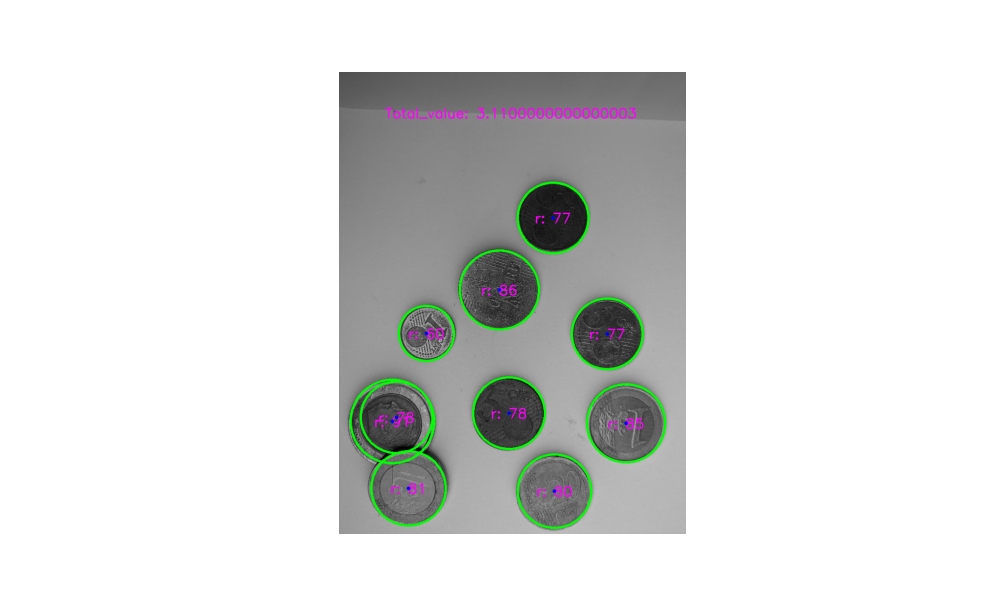

In [26]:
# Define the radii Dictionary, that contains the average radius for each one of the coins
rad_dict = {"1cent":58.8, "2cent":69.0, "5cent":77.6, "10cent":71.8, "20cent":81.6, "50cent":89.4, "1euro":84.4, "2euro":94.25}
# Define the coin values dictionary
val_dict = {"1cent":0.01, "2cent":0.02, "5cent":0.05, "10cent":0.1, "20cent":0.2, "50cent":0.5, "1euro":1, "2euro":2}

# Get the path of an image to detect coins on
path = "Images/rest/coin6.jpg"
out_final, _, angle, edge_pixels, im_gray, _ = preprocess_image(path, sf=0.25, gaussian_kernel=1, thresh1=10, thresh2=65, canny_kernel=3)
fine_tuned_circles, circles, hough_tensor, candidate_pixels = hough_transform_circles(out_final, edge_pixels, angle, 10, 200, im_gray.shape[0], im_gray.shape[1], 0.23, 0.1)

cimg = cv.cvtColor(im_gray, cv.COLOR_GRAY2BGR)
fine_tuned_circles = np.uint16(np.around(fine_tuned_circles))
tot_val = 0
for i, c in enumerate(fine_tuned_circles):
    
    coin = find_closest_coin(c[2], rad_dict)
    if coin != None:
        tot_val += val_dict[coin]

    # Text settings
    text = "r: {}".format(c[2])
    font = cv.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 0, 255)  # White text
    thickness = 2

    # Calculate text size
    (text_width, text_height), _ = cv.getTextSize(text, font, font_scale, thickness)

    # Calculate text position so that it is centered
    text_x = round(c[1]) - text_width // 2
    text_y = round(c[0]) + text_height // 2

    # Put the text
    cv.putText(cimg, text, (text_x, text_y), font, font_scale, font_color, thickness)
    cv.circle(cimg, (round(c[1]), round(c[0])), round(c[2]), (0, 255, 0), 3)
    cv.circle(cimg, (round(c[1]), round(c[0])), 1, (0, 0, 255), 5)

# Text settings
text = "Total_value: {}".format(tot_val)
font = cv.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255, 0, 255)  # White text
thickness = 2

# Calculate text size
(text_width, text_height), _ = cv.getTextSize(text, font, font_scale, thickness)

# Calculate text position so that it is centered
text_x = 100
text_y = 100

# Put the text
cv.putText(cimg, text, (text_x, text_y), font, font_scale, font_color, thickness)

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.set_axis_off()
axs.imshow(cimg)
plt.show()